# Pipeline for the Ilastik API, here we use bees.ipl (3 labels, all features)

In [28]:
import h5py
import matplotlib.pyplot as plt
import cv2
from skimage.morphology import disk, opening, closing
import numpy as np

In [29]:
ILASTIK_PATH = '/Users/fabianprofeta/Desktop/ilastik-1.4.0.post1-OSX.app/Contents/ilastik-release/run_ilastik.sh'
MODEL='bees.ilp'
OUTPUT_FOLDER = './imgs_samples_mask/{nickname}_mask.png'
img = 'img3.jpg'
cv2.imwrite('img3_resized.jpg', cv2.resize(cv2.imread(img), (0,0), fx=0.5, fy=0.5))
IMG = 'img3_resized.jpg'

!$ILASTIK_PATH  --headless --project=$MODEL $IMG

INFO ilastik.app: Using tiktorch executable: ['/Users/fabianprofeta/Desktop/ilastik-1.4.0.post1-OSX.app/Contents/ilastik-release/bin/python', '-m', 'tiktorch.server']
INFO ilastik.app: config file location: <none>
INFO ilastik.app: Starting ilastik from "/Users/fabianprofeta/Desktop/ilastik-1.4.0.post1-OSX.app/Contents/ilastik-release/lib/python3.7".
Starting ilastik from "/Users/fabianprofeta/Desktop/ilastik-1.4.0.post1-OSX.app/Contents/ilastik-release/lib/python3.7".
WARNING 2024-04-07 12:31:12,092 opConservationTracking 69558 4477998592 Could not find any ILP solver
WARNING 2024-04-07 12:31:12,135 opStructuredTracking 69558 4477998592 Could not find any ILP solver
WARNING 2024-04-07 12:31:12,139 structuredTrackingWorkflow 69558 4477998592 Could not find any learning solver. Tracking will use flow-based solver (DPCT). Learning for tracking will be disabled!
INFO ilastik.shell.projectManager: Opening Project: bees.ilp
INFO ilastik.workflows.pixelClassification.pixelClassificationWorkf

In [30]:
filename = "img3_resized_Probabilities.h5"
with h5py.File(filename, "r") as f:
    a_group_key = list(f.keys())[0]
    data = list(f[a_group_key])
    ds_arr = f[a_group_key][:,:,0]  # returns as a numpy array
    print(ds_arr)

[[0.85 0.87 0.87 ... 0.01 0.01 0.  ]
 [0.85 0.87 0.87 ... 0.01 0.   0.  ]
 [0.85 0.87 0.87 ... 0.02 0.01 0.01]
 ...
 [0.   0.   0.   ... 0.11 0.11 0.1 ]
 [0.   0.   0.   ... 0.1  0.09 0.09]
 [0.   0.   0.   ... 0.11 0.1  0.09]]


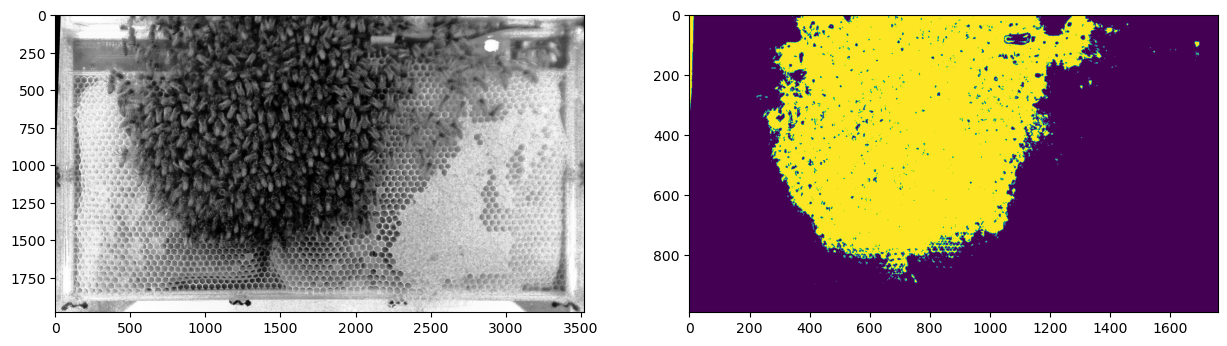

In [31]:
cv2.imwrite('img3_resized_Probabilities.png', ds_arr)
mask = cv2.imread('img3_resized_Probabilities.png', cv2.IMREAD_GRAYSCALE)

fig, ax = plt.subplots(1, 2, figsize=(15, 15))
ax[0].imshow(cv2.imread('img3.jpg'), cmap='gray')
ax[1].imshow(mask)
plt.show()

In [32]:
# morphology
mask_open = opening(mask, disk(9))
mask_closed = closing(mask_open, disk(9))

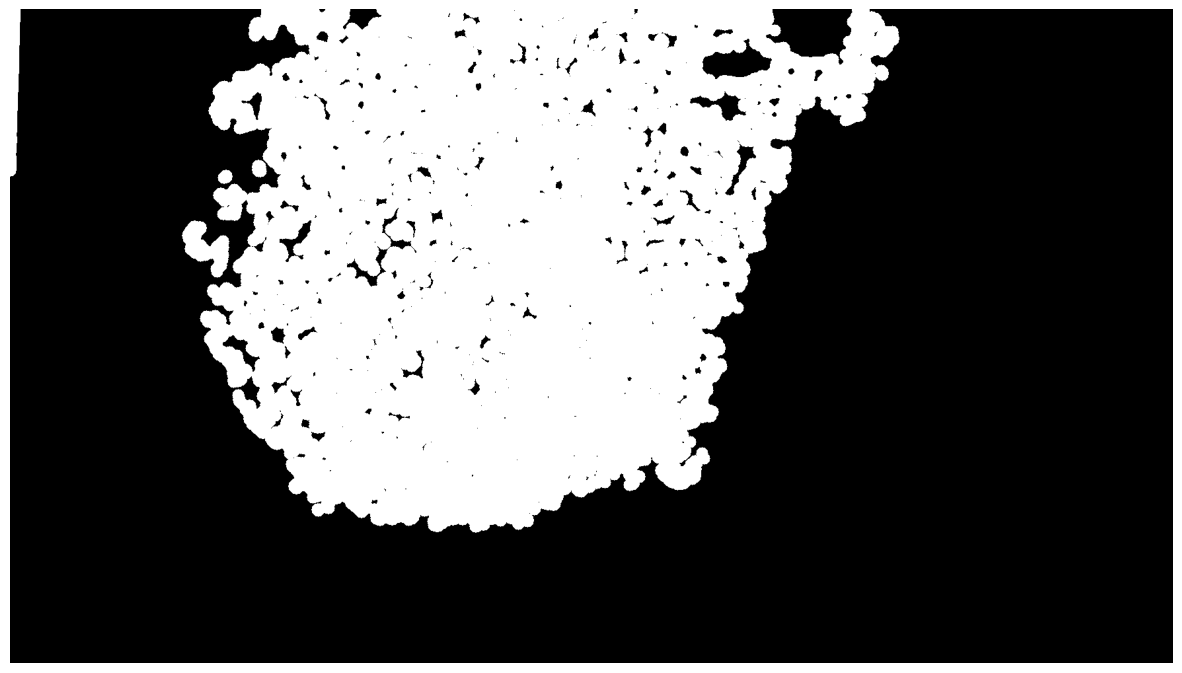

In [33]:
fig, ax = plt.subplots(1, 1, figsize=(15, 15))
ax.imshow(mask_open, cmap='gray')
ax.axis('off')
plt.show()

In [39]:
input_image = cv2.imread(IMG)

# now we can find the contours

img_contour = (mask_closed).astype(np.uint8) #convert to uint8 because findContours only accepts uint8
contours, _ = cv2.findContours(img_contour, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE) #find contours
contour = max(contours, key=cv2.contourArea) #get the biggest contour
img_contour = cv2.cvtColor(img_contour, cv2.COLOR_GRAY2BGR) #convert to BGR because drawContours only accepts BGR
cv2.drawContours(input_image, contour, -1, (255, 255, 255), 15) #draw the biggest contour

# find the centroid of the contour
M = cv2.moments(contour)
cX = int(M["m10"] / M["m00"])
cY = int(M["m01"] / M["m00"])
# plot it on the image
cv2.circle(input_image, (cX, cY), 10, (255, 0, 0), -1)
cv2.putText(input_image, "centroid", (cX - 30, cY - 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2);

ellipse = cv2.fitEllipse(contour)
cv2.ellipse(input_image, ellipse, color=(0,255,0), thickness=15)
print(ellipse[1][0]/ellipse[1][1])

0.736598884819585


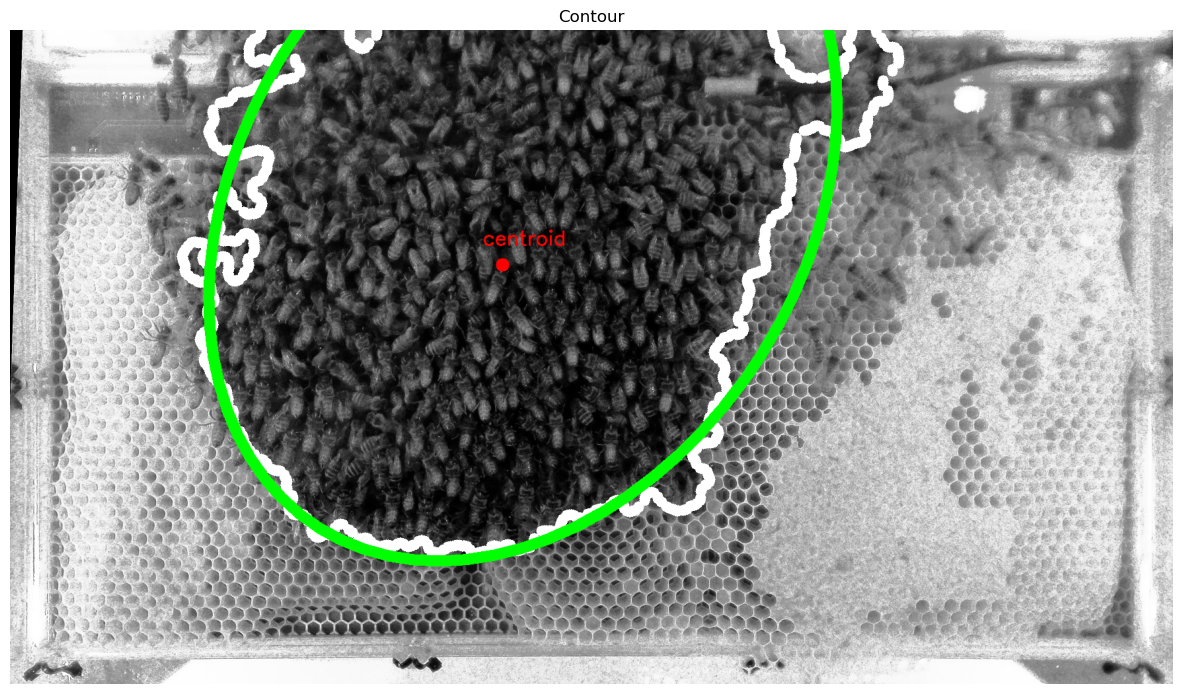

In [35]:
fig, ax = plt.subplots(1, 1, figsize=(15, 15))
ax.imshow(input_image, cmap='gray')
ax.axis('off')
ax.set_title('Contour')
plt.show()